<a href="https://colab.research.google.com/github/saeu5407/daily_tensorflow/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **이미지 분할**

지금까지 해 오던 Image Classification이 아닌, 이미지에서 해당 객체의 위치, 모양 등을 알기 위해 할 수 있는 방법입니다.
이미지의 각 픽셀에 레이블을 붙여 객체의 위치를 알아낼 수 있습니다.

이번에 사용할 데이터는 Parkhi *et al*이 만든 [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)입니다. 데이터 세트는 영상, 해당 레이블과 픽셀 단위의 마스크로 구성됩니다. 마스크는 기본적으로 각 픽셀의 레이블입니다. 각 픽셀은 다음 세 가지 범주 중 하나가 주어집니다:

*   class 1 : 애완동물이 속한 픽셀
*   class 2 : 애완동물과 인접한 픽셀
*   class 3 : 위에 속하지 않는 경우/주변 픽셀

**원본 텐서플로우 튜토리얼 링크**
[원본 URL](https://www.tensorflow.org/tutorials/images/segmentation)

### 데이터 로드 및 전처리

In [23]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-j2veh1vd
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-j2veh1vd


In [24]:
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [25]:
# Oxford-IIIT Pets 데이터 다운로드
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [26]:
# 데이터 정규화 함수
"""
데이터를 1/255로 나누어 정규화
각 클래스에 -1을 적용하여 0,1,2로 변경
"""
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [27]:
# Train set용 데이터 전처리 함수
"""
데이터 사이즈 변경
좌우 Flip등 이미지를 뒤집으며 증강
위에 작성한 normalize 함수 적용
"""
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [28]:
# Test set용 데이터 전처리 함수
"""
Flip이 빠져있는 걸 확인할 수 있다.
"""
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [29]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [30]:
# 데이터셋 전처리
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
# .map(num_parallel_calls) 은 병렬처리를 도와주는 메서드고,
# tf.data.experimental.AUTOTUNE : 동적으로 할당해주는 방법. 

In [31]:
# cache, prefetch 작업 수행
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

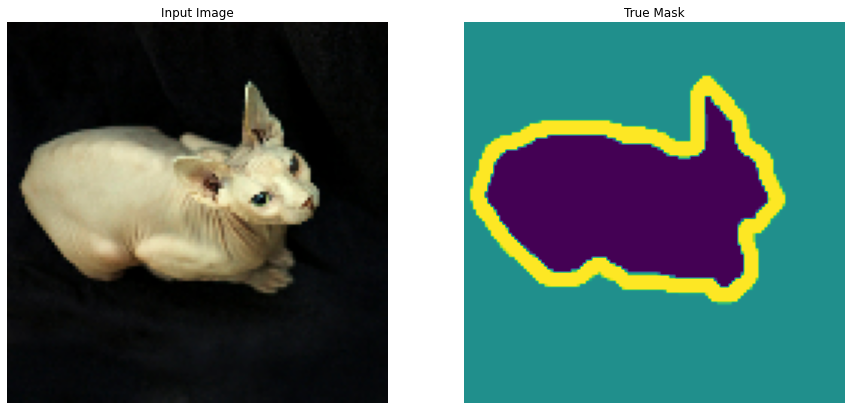

In [32]:
# 데이터 샘플 시각화
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### 모델링

사용할 모델은 U-Net입니다.
U-Net은 인코더와 디코더가 포함된 모델로, 파라미터의 수를 줄이기 위해 인코더 부분을 pre-trained된 모델로 사용할 수 있습니다.

여기서는 MobileNetV2 모델을 인코더로 추가한 전이학습을 수행하겠습니다.
디코더 부분은 pix2pix 구조를 가져왔습니다.

#### 모델 구현

In [33]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 이 층들의 활성화를 이용
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 다운샘플러 구현
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

# 학습 불가능하게 변경
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [34]:
# 업샘플러 구현
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [35]:
# 구현한 다운샘플링, 업샘플링을 합쳐 U-Net 구성
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 다운샘플링
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1]) # reversed는 요소를 뒤집는 방법

  # 업샘플링
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 마지막층 구현
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [37]:
# 컴파일링
"""
손실 함수가 loss.sparse_categorical_crossentropy인 이유

우선 클래스는 0,1,2로 멀티클래스임을 알 수 있다. 그렇기 때문에 categorical_crossentropy를 사용해야 한다.
one-hot encoding을 사용하지 않으므로 각 채널별로 0,1,2를 대응하기 위해 sparse한 loss를 사용하게 된다.
"""
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

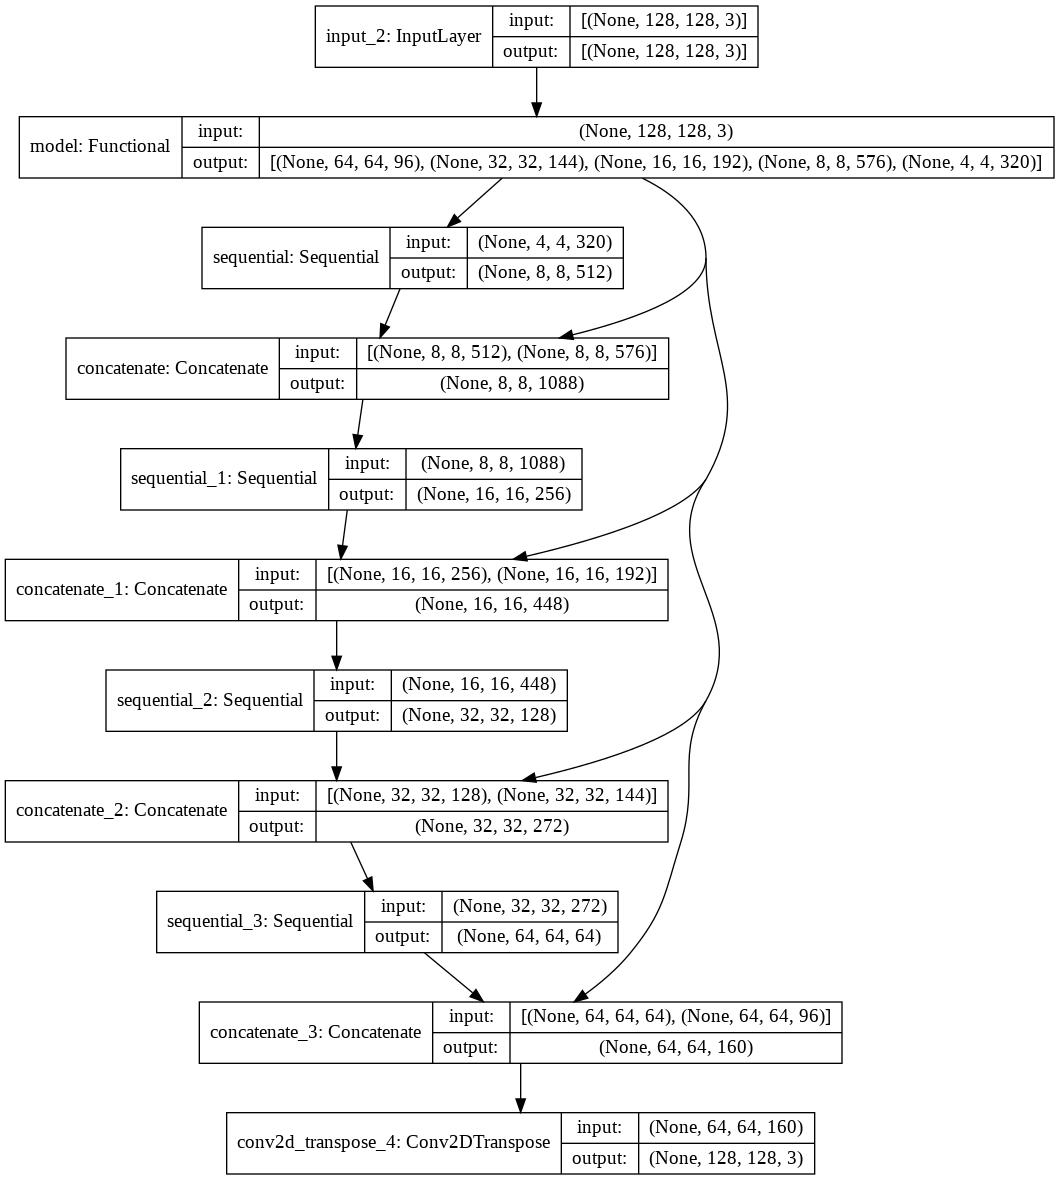

In [38]:
# 모델의 구조 시각화
tf.keras.utils.plot_model(model, show_shapes=True)

In [39]:
# 모델 결과 시각화 함수
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1) # (1,128,128,3) 인풋의 각 차원별 argmax
  pred_mask = pred_mask[..., tf.newaxis].   # (1,128,128)이 되겠죠? tf.newaxis를 추가하여 (1,128,128,1)로 변경
  return pred_mask[0]                       # 최종적으로 첫번째 값만 뽑아서 (128,128,1)로 전처리하게 됩니다.

In [40]:
# 결과물 시각화 함수
"""
이미지, 마스킹이미지, 모델결과(create_mask함수 적용)를 출력하는 함수
위의 함수와 같이 주석 추가했으니 헷갈리면 차원을 보면서 확인
"""
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
# tf.newaxis는 차원 추가로, 맨 앞 배치 차원에 1을 추가하여 predict 수행
# 즉 input 차원인 (128,128,3)을 모델에 넣기 위해 (1,128,128,3)로 변경하는 작업

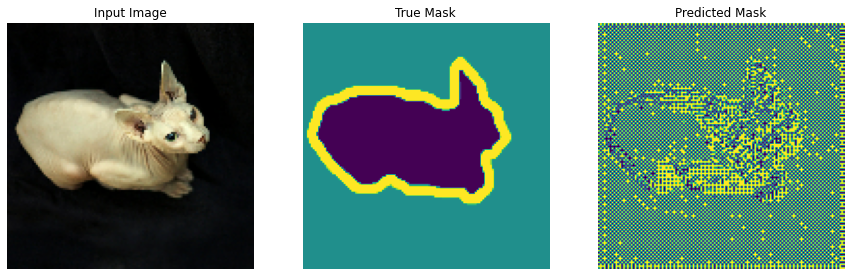

In [41]:
# 훈련 전 샘플을 확인
show_predictions()

#### 함수 플로우 샘플(본인이 헷갈려서 둠)

In [57]:
pred_mask = model.predict(sample_image[tf.newaxis, ...])
pred_mask.shape

(1, 128, 128, 3)

In [59]:
pred_mask

array([[[[-0.12090322,  0.6903215 , -0.5544307 ],
         [-1.1926606 , -0.19131126,  0.691581  ],
         [ 0.05745593,  0.33325964, -1.0501664 ],
         ...,
         [-0.6379042 , -0.20526734,  0.12122475],
         [-0.25042546,  0.44623387, -1.3736846 ],
         [-0.27658778, -0.2319227 ,  0.09099734]],

        [[ 0.2666022 ,  0.6424769 , -0.24474168],
         [ 0.77799195, -0.6911807 ,  1.203665  ],
         [-0.11315289,  0.08524603, -0.6143424 ],
         ...,
         [ 0.5021965 , -0.77385306,  1.1551539 ],
         [ 0.26298082,  0.07206285, -0.40769613],
         [ 0.6831482 , -0.4169246 ,  1.5110005 ]],

        [[ 0.04604772,  0.33988583,  2.6529002 ],
         [ 1.3388847 , -1.3337418 ,  0.2188194 ],
         [-1.6241302 ,  0.3006568 ,  1.2562197 ],
         ...,
         [ 1.462891  , -1.2046319 ,  0.7861141 ],
         [-1.4824775 ,  0.614395  ,  0.42843816],
         [ 0.66489756, -2.1797428 ,  0.17304406]],

        ...,

        [[ 0.4604936 ,  0.1433193 ,  0

In [58]:
tf.argmax(pred_mask, axis=-1)

<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[1, 2, 1, ..., 2, 1, 2],
        [1, 2, 1, ..., 2, 0, 2],
        [2, 0, 2, ..., 0, 1, 0],
        ...,
        [0, 2, 0, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 0, 0],
        [1, 2, 0, ..., 2, 2, 2]]])>

In [61]:
tf.argmax(pred_mask, axis=-1)[..., tf.newaxis][0]

<tf.Tensor: shape=(128, 128, 1), dtype=int64, numpy=
array([[[1],
        [2],
        [1],
        ...,
        [2],
        [1],
        [2]],

       [[1],
        [2],
        [1],
        ...,
        [2],
        [0],
        [2]],

       [[2],
        [0],
        [2],
        ...,
        [0],
        [1],
        [0]],

       ...,

       [[0],
        [2],
        [0],
        ...,
        [2],
        [2],
        [2]],

       [[2],
        [2],
        [2],
        ...,
        [2],
        [0],
        [0]],

       [[1],
        [2],
        [0],
        ...,
        [2],
        [2],
        [2]]])>

#### 모델 훈련

In [62]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n에포크 이후 예측 예시 {}\n'.format(epoch+1))

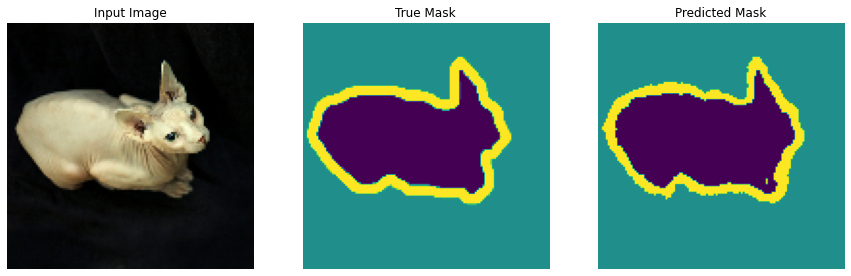


에포크 이후 예측 예시 20



In [63]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

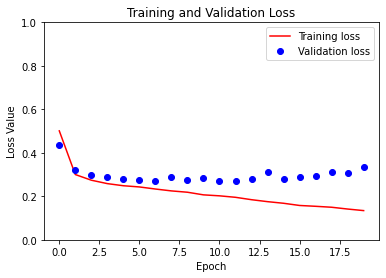

In [64]:
# Loss 시각화
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()